# Assessment 2


 Setup
## Custom install and dataset download

In [3]:
!pip install rdkit torchinfo
!pip install git+https://github.com/bp-kelley/descriptastorus
URL = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv"
!wget -O 'delaney.csv' $URL

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 22.5 MB/s eta 0:00:00
  Cloning https://github.com/bp-kelley/descriptastorus to /tmp/pip-req-build-tkab1e6j
  Running command git clone --filter=blob:none --quiet https://github.com/bp-kelley/descriptastorus /tmp/pip-req-build-tkab1e6j
  Resolved https://github.com/bp-kelley/descriptastorus to commit 9a190343bcd3cfd35142d378d952613bcac40797
  Preparing metadata (setup.py) ... done
  Created wheel for descriptastorus: filename=descriptastorus-2.7.0.3-py3-none-any.whl size=1082893 sha256=a817db446b6a6828d95bcba36675651d5e11a7940c8ce31812d7d1bb476b29da
  Stored in directory: /tmp/pip-ephem-wheel-cache-vrcbll80/wheels/a5/37/b0/bc8b04ad2a1d1f3e17a7bff134d2a7e63621914e0a01d983a6
Successfully built descriptastorus
--2025-04-02 22:16:17--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.193.106, 16.15.4.249

## Import libraries

In [4]:
from pprint import pprint
import IPython.display as ipd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tqdm.auto as tqdm

import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
import rdkit.Chem.Draw
from rdkit.Chem.Draw import IPythonConsole
import descriptastorus.descriptors

import sklearn.model_selection
import sklearn.metrics
import xgboost as xgb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as torch_data
import torchinfo

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.__version__)

2.6.0+cu124


## Utility functions

In [5]:
def display_header(text, n=2):
  ipd.display(ipd.HTML(f"<h{n}>{text}</h{n}>"))

def cast_tensor(x):
    """Cast tensor to numpy array."""
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    elif isinstance(x, list):
        return np.array(x)
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise ValueError("Input must be torch.Tensor or np.ndarray or list")

def evaluate(y_true, y_pred, extra_info=None):
    """Evaluate regression performance."""
    info = extra_info or {}
    y_true_np = cast_tensor(y_true).ravel()
    y_pred_np = cast_tensor(y_pred).ravel()
    r2 = sklearn.metrics.r2_score(y_true_np, y_pred_np)
    mae = sklearn.metrics.mean_absolute_error(y_true_np, y_pred_np)
    rmse = float(np.sqrt(sklearn.metrics.mean_squared_error(y_true_np, y_pred_np)))
    return info | {'r2': r2, 'mae': mae, 'rmse': rmse}

# Data [1 pt total]

## Dataset Loading

In this section, we will load the Delaney dataset, a widely used dataset in cheminformatics for modeling the solubility of molecules. We will use pandas to load the CSV file and inspect its basic properties.

This is the same task we proposed in the example project early in the class. Understanding the data is the first crucial step in any machine learning project. We'll start by loading the dataset and getting a feel for its structure and content.

In [6]:
SMI_COL = 'smiles'
Y_COL = 'measured log solubility in mols per litre'
df = pd.read_csv('delaney.csv')
print(df.columns)
print(df.shape)
df.head()

Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles'],
      dtype='object')
(1128, 10)


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


## Dataset splitting

To properly evaluate our models, we need to split the dataset into training, validation, and test sets. This ensures that we can tune our model parameters on the validation set and get an unbiased estimate of performance on the unseen test set. We will use scikit-learn's `train_test_split` for this purpose, ensuring a consistent split using a `random_state`.

In [7]:
index = np.arange(df.shape[0])
train_val_index, test_index = sklearn.model_selection.train_test_split(index, test_size=0.2, random_state=42)
train_index, val_index = sklearn.model_selection.train_test_split(train_val_index, test_size=0.15/0.8, random_state=42)

smi = df[SMI_COL].to_numpy(str)
y = df[Y_COL].to_numpy(float).reshape(-1, 1)

## Feature generators

Machine learning models require numerical input features. For molecules, we can generate different types of features. In this assignment, we will explore two feature representations:

1.  **Baseline 2D descriptors**: These are classical molecular descriptors calculated from the 2D structure of the molecule. We will use `descriptastorus` library to generate these.
2.  **Graph representation**: Representing a molecule as a graph, where atoms are nodes and bonds are edges. This representation is particularly suitable for Graph Neural Networks. We will implement a function to convert SMILES strings to graph tensors.

In [8]:
def smiles_to_baseline_features(smiles_list):
    """Convert SMILES to baseline 2D descriptors."""
    generator = descriptastorus.descriptors.RDKit2DHistogramNormalized()
    values = [generator.process(s)[1:] for s in tqdm.tqdm(smiles_list)]
    return np.stack(values, dtype=np.float32)

def smiles_to_graph(smiles):
    """Converts SMILES string to graph representation with adjacency matrix."""
    mol = rdkit.Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")

    atom_symbols = [atom.GetSymbol() for atom in mol.GetAtoms()]
    bond_types = [bond.GetBondType() for bond in mol.GetBonds()]
    num_atoms = len(atom_symbols)

    atom_type_vocab = ['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Br', 'I', 'H']
    atom_feature_matrix = []
    for symbol in atom_symbols:
        feature = [0] * len(atom_type_vocab)
        if symbol in atom_type_vocab:
            feature[atom_type_vocab.index(symbol)] = 1
        atom_feature_matrix.append(feature)
    node_features = torch.tensor(atom_feature_matrix, dtype=torch.float32)

    adjacency_matrix = np.zeros((num_atoms, num_atoms), dtype=np.float32)
    for bond in mol.GetBonds():
        start_atom_index = bond.GetBeginAtomIdx()
        end_atom_index = bond.GetEndAtomIdx()
        adjacency_matrix[start_atom_index, end_atom_index] = 1.0
        adjacency_matrix[end_atom_index, start_atom_index] = 1.0

    adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float32)
    adjacency_matrix = adjacency_matrix + torch.eye(num_atoms, dtype=torch.float32)
    globals_vector = torch.zeros(1, dtype=torch.float32)

    return node_features, adjacency_matrix, globals_vector

## Example Molecule and Graph Tensors

Let's visualize an example molecule from the dataset and see the output of our feature generation functions. We will randomly select a molecule and display its 2D rendering, the graph tensor representation, and the baseline feature vector. This helps to understand the input data formats for our models.

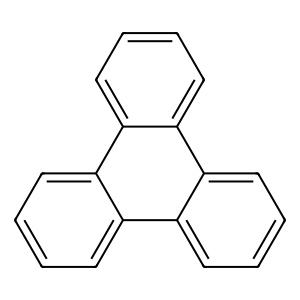

(tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1

  0%|          | 0/1 [00:00<?, ?it/s]

array([[9.24834728e-01, 2.46477246e-01, 7.03949258e-02, 8.98762941e-02,
        6.74047172e-02, 1.15678094e-01, 1.45530194e-01, 1.11607812e-01,
        1.71662018e-01, 1.08157568e-01, 2.66008615e-01, 1.92543477e-01,
        3.94007593e-01, 2.88050175e-01, 4.17999268e-01, 1.02627181e-01,
        9.94449615e-01, 1.08377583e-01, 7.79354572e-02, 8.98162872e-02,
        9.14724052e-01, 1.89733282e-01, 1.96123734e-01, 9.80638623e-01,
        2.24645719e-01, 4.94934656e-02, 7.00048986e-04, 5.20036381e-04,
        3.90027300e-04, 2.74019185e-02, 6.87428117e-01, 1.86153024e-01,
        5.39537780e-02, 9.99979973e-01, 2.99120937e-02, 2.88520195e-02,
        3.39093745e-01, 8.82661790e-02, 1.50010499e-04, 1.50073538e-04,
        1.50010499e-04, 1.60078445e-04, 9.99880016e-01, 1.01043447e-03,
        9.99970019e-01, 9.99929965e-01, 8.76281321e-01, 1.73982173e-01,
        5.89741282e-02, 5.67289710e-01, 4.05228361e-02, 8.27157915e-01,
        8.33728373e-01, 7.57032990e-01, 9.98929918e-01, 9.476463

In [9]:
random_index = np.random.choice(df.shape[0])
smiles = smi[random_index]
mol = rdkit.Chem.MolFromSmiles(smiles)
display_header('Molecule rending')
ipd.display(rdkit.Chem.Draw.MolToImage(mol))
one_graph = smiles_to_graph(smiles)
display_header('graph tensor')
pprint(one_graph)
display_header('baseline vector')
data = smiles_to_baseline_features([smiles])
pprint(data)

## Exploratory Data Analysis (EDA) [.5 pt]

**Exercise: EDA on dataset.**

**Goal:** Perform some Exploratory Data Analysis (EDA) on this dataset to understand its characteristics and properties.

**Expected output:** Code and visualizations

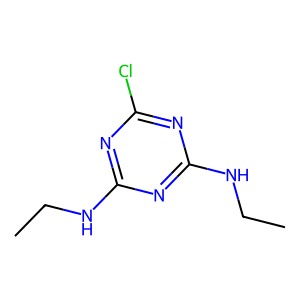

[-4.55]


(1128, 10)


this shows we have 1128 samples with 10 columns of data


In [10]:
random_index = np.random.choice(df.shape[0])
smiles = smi[random_index]
mol = rdkit.Chem.MolFromSmiles(smiles)
display_header('Molecule rending')
ipd.display(rdkit.Chem.Draw.MolToImage(mol))
display_header('Label')
print(y[random_index])

display_header('shape')
print(df.shape)
display_header('columns')

df.columns
len(df.columns)
print(f"this shows we have {df.shape[0]} samples with {df.shape[-1]} columns of data")

In [11]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 10 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Compound ID                                      1128 non-null   object 
 1   ESOL predicted log solubility in mols per litre  1128 non-null   float64
 2   Minimum Degree                                   1128 non-null   int64  
 3   Molecular Weight                                 1128 non-null   float64
 4   Number of H-Bond Donors                          1128 non-null   int64  
 5   Number of Rings                                  1128 non-null   int64  
 6   Number of Rotatable Bonds                        1128 non-null   int64  
 7   Polar Surface Area                               1128 non-null   float64
 8   measured log solubility in mols per litre        1128 non-null   float64
 9   smiles                        

,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
count,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000
mean,-2.988192,1.058511,203.937074,0.701241,1.390957,2.177305,34.872881,-3.050102
std,1.683220,0.238560,102.738077,1.089727,1.318286,2.640974,35.383593,2.096441
min,-9.702000,0.000000,16.043000,0.000000,0.000000,0.000000,0.000000,-11.600000
25%,-3.948250,1.000000,121.183000,0.000000,0.000000,0.000000,0.000000,-4.317500
50%,-2.870000,1.000000,182.179000,0.000000,1.000000,1.000000,26.300000,-2.860000
75%,-1.843750,1.000000,270.372000,1.000000,2.000000,3.000000,55.440000,-1.600000
max,1.091000,2.000000,780.949000,11.000000,8.000000,23.000000,268.680000,1.580000


That is a useful method. We see that the mean predicted log solubility is negative, indicating that the argument is on average between 0 and 1. In addition the max is 1.58, and the min is -11.6. The standard deviation is 2, indicating that most of the cases are between -5 and -1 (approximately). The spread of the ESOL is smaller than the actual, which is expected for a generalizable model.\\

An important thing to note here is that the dataset is complete, and there are no missing data.

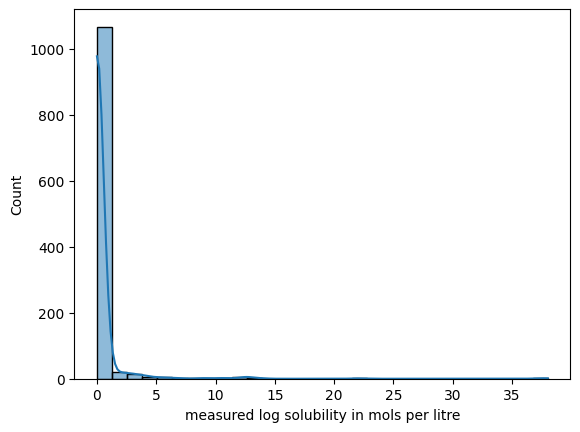

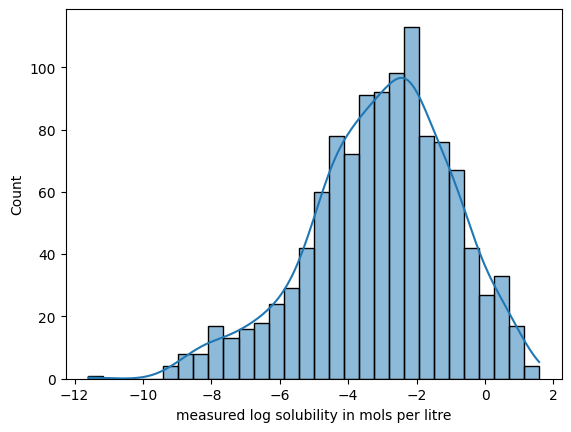

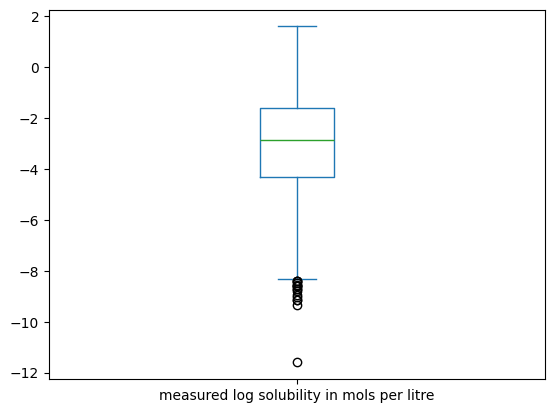

There are 341 molecules with near zero solubility


In [12]:
solubility = 10**df[Y_COL]
sns.histplot(solubility, kde=True, bins=30)
plt.show()


sns.histplot(df[Y_COL], kde=True, bins=30)
plt.show()
ax=df[Y_COL].plot(kind='box')
plt.show()
print(f'There are {solubility[solubility < 1e-4].shape[0]} molecules with near zero solubility')


This might be a problem, we see that a third of the dataset has a solubility of nearly 0. After investigating the chemical interpertation of this, it turns out that this is acceptable and in fact they go even lower, to 1e-10. I guess this is why they took the log in the first place. Oh well, now I know.

There are some strong outliers such as the -11.7 point, which is clearly an outlier. Earlier I mentioned that the predictive model's minimum was aroind -9, and for good reason. This -11.7 is far out from the rest of the distribution. It may be wise to disclude this sample during our training.


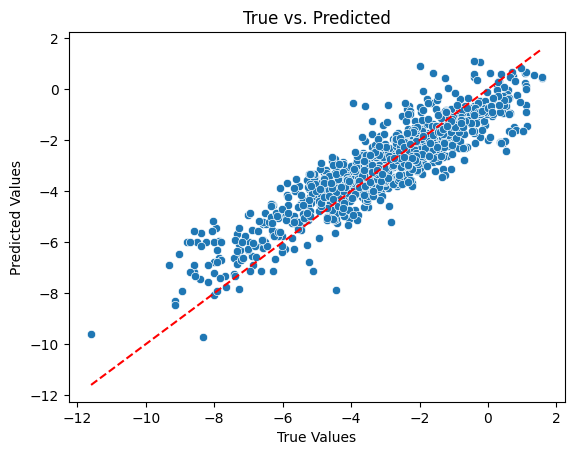

The r² value of the baseline predictions is 0.81


In [13]:
labels = df[Y_COL]
pred =df['ESOL predicted log solubility in mols per litre']
sns.scatterplot(x=labels, y=pred)
plt.plot([labels.min(), labels.max()], [labels.min(), labels.max()], '--r')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs. Predicted")
plt.show()
res = evaluate(np.array(labels), np.array(pred))
print(f'The r\u00B2 value of the baseline predictions is {res["r2"]:.2f}')

I read ahead in the assignment so now I know that we are aiming to beat their model. It also sees that the prediction model has a different slope than the correct predition slope. This reveals why the erros may occur, and there may be a easy hurdle here we can overcome.

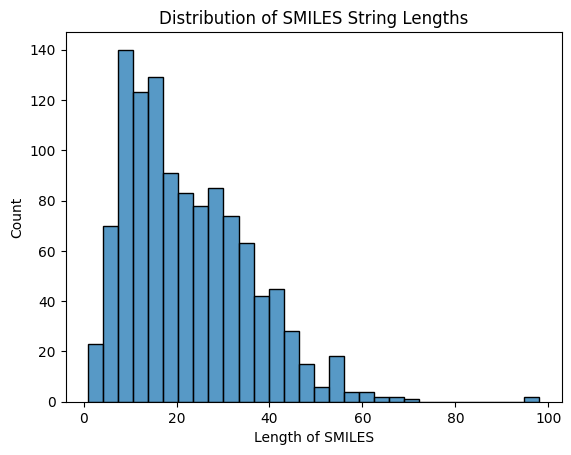

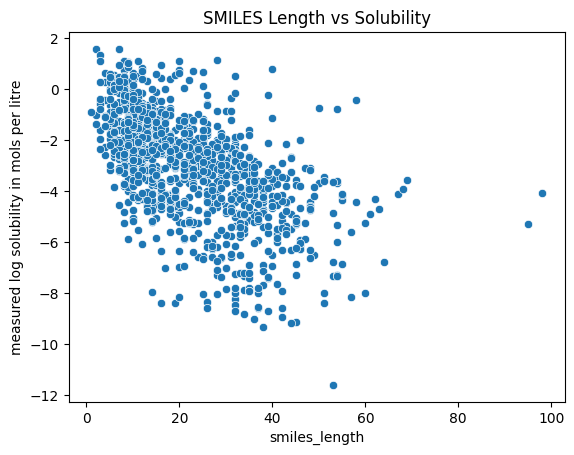

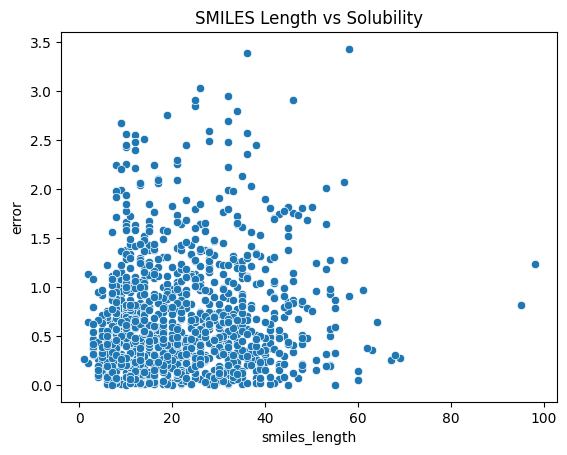

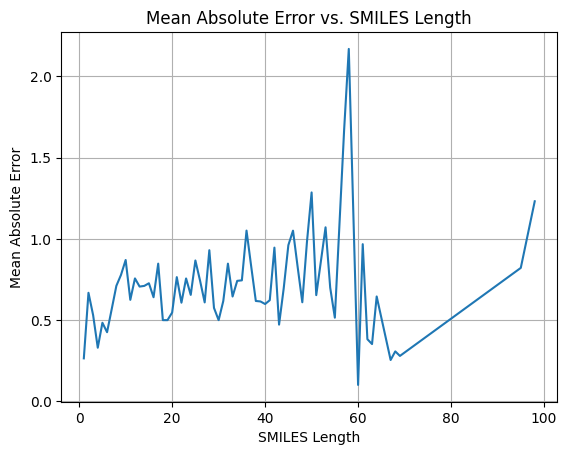

In [14]:
df['smiles_length'] = df[SMI_COL].apply(len)
sns.histplot(df['smiles_length'], bins=30)
plt.title("Distribution of SMILES String Lengths")
plt.xlabel("Length of SMILES")
plt.ylabel("Count")
plt.show()

sns.scatterplot(x='smiles_length', y=Y_COL, data=df)
plt.title("SMILES Length vs Solubility")
plt.show()

df['error'] = df[Y_COL] - df['ESOL predicted log solubility in mols per litre']
df['error'] = df['error'].abs()
sns.scatterplot(x='smiles_length', y='error', data=df)
plt.title("SMILES Length vs Solubility")
plt.show()

error_by_length = df.groupby('smiles_length')['error'].mean().reset_index()
sns.lineplot(x='smiles_length', y='error', data=error_by_length)
plt.title("Mean Absolute Error vs. SMILES Length")
plt.xlabel("SMILES Length")
plt.ylabel("Mean Absolute Error")
plt.grid(True)
plt.show()

Here we explore the SMILES. First, we plot the counts of the size in order to see what we're working with. It seems that most of the SMILES are less than 50, with the peak around 20.

## EDA Reflection [.5 pt]

Explain why you select these figures for the EDA, what do they tell you? What questions are you trying to answer?

**Exercise: Reflect on the purpose of your EDA.**

**Goal:** Explain your choices of EDA techniques and interpret the resulting visualizations in the context of understanding the Delaney solubility dataset and informing your modeling approach. What insights did you gain from the EDA that might be helpful for building effective models?

**Goal:** Reflect on the purpose of your EDA.

**Expected output:** Text.


My EDA approach started off with statical understanding of the dataset, then I began visualizing it, and I ended off with exlporing the domin specific implications. An important thing that I discovered is that the dataset is complete. This might be obvious and expected given the polished nature of the dataset, but it is imperative to use this understanding in shaping our data processing.

The statistical exploration revealed that the data is normally distributed with a singificant outlier in the targets that is not captured in the predictions. This is totally understandable as it is -11.7 and the next lowest is -9, with the mean around 2. It might be wise to drop such examples. I also was interested in seeing if many of the values were close to zero and could maybe represent the same thing. I reversed the log and clipped the values and found that most of them were less than 1e-4, which is programatically zero. My point was to determine if this could explain any bias, but it turns out that the log value is used for good reason, the solubility is measured on a wide range of orders of magnititude. So this exploration led to a dead end, but this is a good reminder that not all paths lead somewhere but are still worth exploring for a good data scientist.

The next thing I did was evaluate the predictions on our metric to see how good the baseline is, and it turns our to be worse than we aim to get.

Now, I moved to looking into the SMILES and trying to gain an insight from their distributions. I see that there is a shap decine in counts past 40 selfies, indiciating that it might be worth clipping and only using a max length of 40-50. In some models and applications, such cases might be difficult to learn, so if we find that we are not able to get an accuracy above a respectable amount, we can try clipping the length to see if the issue is a model problem or data problem. And so I plotted the mean error and SMILES size and discovered that there is indeed such a trend past 50. It has a huge spike at 60 and then comes back down and increases steadily for the largest selfies. This means length and thus molecular weight are of interest in our modelling.

Now we are ready to develop a model to tackle this dataset. How exciting.


# Baselines [.5 pt total]

## XGboost
Before diving into Graph Neural Networks, it's useful to establish a performance baseline using a simpler, non-graph-based model. Here, we will use XGBoost, a powerful gradient boosting algorithm, with the 2D molecular descriptors we generated earlier. This will give us a reference point to compare against our GNN models.

It's always a good practice to start with simpler models to establish a baseline performance. This allows us to understand the complexity of the task and provides a benchmark against which we can measure the improvements offered by more sophisticated models like GNNs. We will use XGBoost, a robust and widely used algorithm, as our baseline.

**Exercise: Implement the XGBoost.**

**Goal:** Implement a baseline for this task.

**Expected output:** Code and Train/val performance metrics.

In [15]:
# Generate baseline features
X = smiles_to_baseline_features(smi)

# Split data using earlier indices
X_train, y_train = X[train_index], y[train_index]
X_val, y_val = X[val_index], y[val_index]
X_test, y_test = X[test_index], y[test_index]

# Train the XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train.ravel(), eval_set=[(X_val, y_val.ravel())], verbose=False)

# Predict and evaluate
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)
y_test_pred = xgb_model.predict(X_test)

# Print performance metrics
print("Train Performance:")
pprint(evaluate(y_train, y_train_pred))

print("\nValidation Performance:")
pprint(evaluate(y_val, y_val_pred))

print("\nTest Performance:")
pprint(evaluate(y_test, y_test_pred))


  0%|          | 0/1128 [00:00<?, ?it/s]

Train Performance:
{'mae': 0.01662353720842183,
 'r2': 0.9997387216318558,
 'rmse': 0.03422466655268597}

Validation Performance:
{'mae': 0.38925351583572004, 'r2': 0.9207937832361803, 'rmse': 0.53003798512304}

Test Performance:
{'mae': 0.47357951388855063,
 'r2': 0.8958116772239798,
 'rmse': 0.701767573817295}


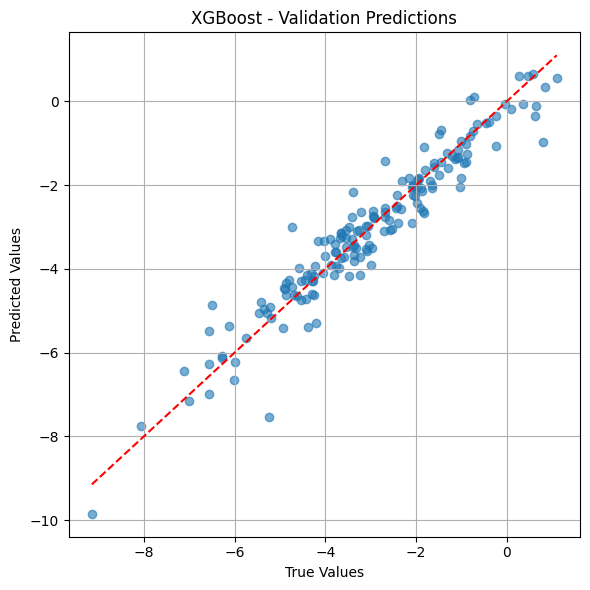

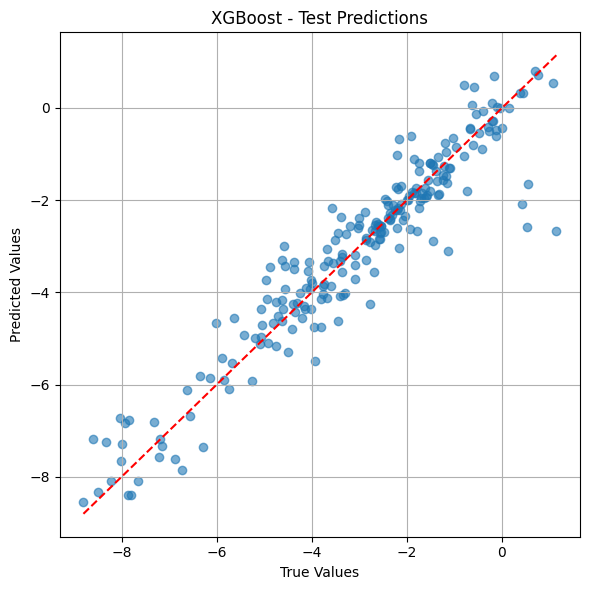

In [16]:
def plot_preds(y_true, y_pred, title="Predictions vs True"):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_preds(y_val, y_val_pred, title="XGBoost - Validation Predictions")
plot_preds(y_test, y_test_pred, title="XGBoost - Test Predictions")


node_dim = 10

Cleary the baseline is really good. We may have overfit, but even so, this is a valuable baseline.


# Graphs and Graph Neural Network (GNN) [2pt]

## Grraph Dataset and loader definition

To work with graph data in PyTorch, we need to create a custom dataset and dataloader. The `MolGraphDataset` class will handle loading molecules and converting them into graph representations. The `mol_graph_collate_fn` will take care of batching graphs, which involves padding graphs to the same size within a batch for efficient processing.

Graph Neural Networks operate on graph structured data. To feed our molecular graph data into a GNN, we need to define a PyTorch Dataset and DataLoader. This section sets up the data pipeline for training our GNN models.

In [17]:
class MolGraphDataset(torch_data.Dataset):
    """Dataset for molecule graphs."""
    def __init__(self, smiles_list, targets):
        """
        Args:
            smiles_list (list): List of SMILES strings.
            targets (list): List of target values corresponding to each SMILES.
        """
        self.smiles_list = smiles_list
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.smiles_list)

    def __getitem__(self, idx):
        """Returns graph and target for a given index."""
        smiles = self.smiles_list[idx]
        target = self.targets[idx]
        node_features, adjacency_matrix, globals_vector = smiles_to_graph(smiles)
        return (node_features, adjacency_matrix, globals_vector), target

def mol_graph_collate_fn(batch):
    """
    Custom collate function for molecule graphs with padding.
    Args:
        batch (list): List of tuples, where each tuple is ((node_features, adjacency_matrix, globals_vector), target).

    Returns:
        tuple: Padded batched graph data (stacked tensors) and batched targets (tensor).
              Node features and adjacency matrices are padded to the maximum number of nodes in the batch.
    """
    graphs = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    node_features_list = [graph[0] for graph in graphs]
    adjacency_matrix_list = [graph[1] for graph in graphs]
    globals_vector_list = [graph[2] for graph in graphs] # although globals are not used

    # Find max number of nodes in batch
    max_num_nodes = max([nf.size(0) for nf in node_features_list])

    padded_node_features_list = []
    padded_adjacency_matrix_list = []

    for idx, (nf, adj) in enumerate(zip(node_features_list, adjacency_matrix_list)):
        num_nodes = nf.size(0)
        # Node feature padding
        padded_nf = torch.cat([nf, torch.zeros(max_num_nodes - num_nodes, nf.size(1))], dim=0)
        padded_node_features_list.append(padded_nf)

        # Adjacency matrix padding
        padded_adj = torch.cat([adj, torch.zeros(num_nodes, max_num_nodes - num_nodes)], dim=1) # Pad rows
        padded_adj = torch.cat([padded_adj, torch.zeros(max_num_nodes - num_nodes, max_num_nodes)], dim=0) # Pad columns
        padded_adjacency_matrix_list.append(padded_adj)

    # Stack padded features and matrices
    batched_node_features = torch.stack(padded_node_features_list) # Shape: [batch_size, max_num_nodes, node_feature_dim]
    batched_adjacency_matrices = torch.stack(padded_adjacency_matrix_list) # Shape: [batch_size, max_num_nodes, max_num_nodes]
    batched_globals_vectors = torch.stack(globals_vector_list) # Shape: [batch_size, 1, global_feature_dim] # No padding for globals
    batched_targets = torch.stack(targets)
    return (batched_node_features, batched_adjacency_matrices, batched_globals_vectors), batched_targets

## Create Graph datasets and loaders

With the dataset and collate function defined, we can now create the actual datasets for training, validation, and testing. We also create the corresponding data loaders, which will handle batching and shuffling of the data during training. Let's inspect the shape of a sample batch to understand the data format that will be fed into our GNN model.

In [18]:
BATCH_SIZE = 32
train_dataset = MolGraphDataset(smi[train_index], y[train_index])
val_dataset = MolGraphDataset(smi[val_index], y[val_index])
test_dataset = MolGraphDataset(smi[test_index], y[test_index])

train_loader = torch_data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                     shuffle=True, collate_fn=mol_graph_collate_fn )
val_loader = torch_data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                    shuffle=False, collate_fn=mol_graph_collate_fn)
test_loader = torch_data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                    shuffle=False, collate_fn=mol_graph_collate_fn)

sample_batch, sample_y = next(iter(train_loader))
node_dim = sample_batch[0].shape[2] # Corrected index to shape[2]
adj_dim = sample_batch[1].shape[2] # Corrected index to shape[2]
global_dim = sample_batch[2].shape[1] # Corrected index to shape[2]
display_header(f'nodes: {sample_batch[0].shape}')
display_header(f'adj: {sample_batch[1].shape}')
display_header(f'globals: {sample_batch[2].shape}')

## Layer definition [.5 pt]

**Exercise: Implement the Graph Convolution Layer**

**Goal:** Translate the mathematical formulation of a Graph Convolution Layer into PyTorch code. Implement the `GraphConvLayer` class based on the following equation for updating node features in a graph convolutional layer:

$$
\mathbf{h}_i^{(l+1)} = \sigma \left( \sum_{j \in \mathcal{N}(i) \cup \{i\}} \mathbf{W}^{(l)} \mathbf{h}_j^{(l)} \right)
$$

Where:
- $\mathbf{h}_i^{(l)}$ is the feature vector of node $i$ in layer $l$.
- $\mathbf{W}^{(l)}$ is the weight matrix for layer $l$.
- $\mathcal{N}(i)$ is the set of neighbors of node $i$.
- $\sigma$ is an activation function.

Implement the `forward` function of the `GraphConvLayer` class to perform this computation. You will need to use matrix multiplication and summation operations in PyTorch.


**Expected output:** Code.

In [19]:
class GraphConvLayer(nn.Module):
    """Simple Graph Convolution Layer."""
    def __init__(self, in_features, out_features):
        """
        Args:
            in_features (int): Number of input node features.
            out_features (int): Number of output node features.
        """
        super(GraphConvLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.activation = nn.ReLU()

    def forward(self, node_features, adjacency_matrix):
        """
        Args:
            node_features (torch.Tensor): Node feature matrix (B, N, in_features).
            adjacency_matrix (torch.Tensor): Adjacency matrix (B, N, N).
        Returns:
            torch.Tensor: Updated node features (B, N, out_features).
        """
        out = torch.bmm(adjacency_matrix, node_features) # (B, N, in_features)
        out = self.linear(out)  # (B, N, F_out)
        out = self.activation(out)
        return out

## Model definition [.5 pt]

**Exercise: Implement the Graph Neural Network Model**

**Goal:** Construct a complete Graph Neural Network (GNN) model for regression. Implement the `GNN` class, which utilizes the `GraphConvLayer` you defined earlier. This model should consist of multiple graph convolutional layers followed by a global pooling operation and a final linear layer for regression.

**Expected output:** Code.

In [20]:
class GNN(nn.Module):
    """Simple Graph Network using Graph Convolution for regression."""
    def __init__(self, node_feature_dim, hidden_dim, num_layers, dropout=0.1):
        """
        Args:
            node_feature_dim (int): Dimension of node features.
            hidden_dim (int): Hidden dimension for GNN layers.
            num_layers (int): Number of Graph Convolution layers.
        """
        super(GNN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GraphConvLayer(node_feature_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.layers.append(GraphConvLayer(hidden_dim, hidden_dim))
        self.dropout = dropout

        self.global_pool = nn.AdaptiveMaxPool1d(1)
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, batched_node_features, batched_adjacency_matrices, batched_globals_vectors):
        """
        Args:
            batched_node_features (torch.Tensor): Batched node feature matrix (B, N, node_feature_dim).
            batched_adjacency_matrices (torch.Tensor): Batched adjacency matrix (B, N, N).
            batched_globals_vectors (torch.Tensor): Batched global vectors (B, 1, global_feature_dim).
        Returns:
            torch.Tensor: Predicted solubility value. (B, 1)
        """
        for layer in self.layers:
            batched_node_features = layer(batched_node_features, batched_adjacency_matrices)
            # batched_node_features = F.dropout(batched_node_features, p=self.dropout, training=self.training)

        batched_node_features = batched_node_features.permute(0, 2, 1)  # [B, F, N]
        batched_node_features = self.global_pool(batched_node_features)  # [B, F, 1]
        batched_node_features = batched_node_features.squeeze(-1)  # [B, F]

        prediction = self.linear(batched_node_features)  # [B, 1]
        return prediction

## Instanciate a model

This snippet should work if your model definition is correct. We will instantiate the `GNN` model and print a summary of the model architecture and parameters using `torchinfo`. This is a useful step to verify that our model is defined as intended before training.

**Goal:** Instantiate the GNN model and verify its structure.

**Expected output:** Code to instantiate the GNN model and the model summary output from `torchinfo`.

In [21]:
model_gnn = GNN(node_dim, 64, 4, dropout=0.1)

print(torchinfo.summary(model_gnn, input_data=sample_batch))

Layer (type:depth-idx)                   Output Shape              Param #
GNN                                      [32, 1]                   --
├─ModuleList: 1-1                        --                        --
│    └─GraphConvLayer: 2-1               [32, 27, 64]              --
│    │    └─Linear: 3-1                  [32, 27, 64]              704
│    │    └─ReLU: 3-2                    [32, 27, 64]              --
│    └─GraphConvLayer: 2-2               [32, 27, 64]              --
│    │    └─Linear: 3-3                  [32, 27, 64]              4,160
│    │    └─ReLU: 3-4                    [32, 27, 64]              --
│    └─GraphConvLayer: 2-3               [32, 27, 64]              --
│    │    └─Linear: 3-5                  [32, 27, 64]              4,160
│    │    └─ReLU: 3-6                    [32, 27, 64]              --
│    └─GraphConvLayer: 2-4               [32, 27, 64]              --
│    │    └─Linear: 3-7                  [32, 27, 64]              4,160
│    

## Basic training/evaluation

Do not modify this code, use as is.

In [22]:
def evaluate_model(model, data_loader, criterion, info):
    """Evaluates the model on the given dataloader."""
    model.eval()
    all_predictions = []
    all_targets = []
    total_loss = 0.0  # Initialize total_loss
    with torch.no_grad():
        for (batch_graphs, batch_targets) in data_loader:
            batched_node_features, batched_adjacency_matrices, batched_globals_vectors = batch_graphs
            batch_predictions = model(batched_node_features, batched_adjacency_matrices, batched_globals_vectors)
            loss = criterion(batch_predictions, batch_targets) # Calculate loss for this batch
            total_loss += loss.item() * len(batch_targets) # Accumulate batch loss
            all_predictions.extend(batch_predictions.tolist())
            all_targets.extend(batch_targets.tolist())

    avg_loss = total_loss / len(data_loader.dataset) # Calculate average loss over dataset
    extra_info = info | {'loss': avg_loss} # Use average loss in info
    return evaluate(all_targets, all_predictions, extra_info)

In [23]:
def train_loop(model, train_loader, val_loader, epochs, learning_rate, base_info):
    """Simple training loop with evaluation."""
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    history = []
    pbar = tqdm.tqdm(range(epochs), desc="Epochs")
    for epoch in pbar:
        model.train()
        train_loss = 0.0
        for (batch_graphs, batch_targets) in train_loader:
            batched_node_features, batched_adjacency_matrices, batched_globals_vectors = batch_graphs
            optimizer.zero_grad()
            batch_predictions = model(batched_node_features, batched_adjacency_matrices, batched_globals_vectors)
            loss = criterion(batch_predictions, batch_targets)
            loss.backward()
            optimizer.step()

        info = base_info | {'epoch': epoch+1}
        train_metrics = evaluate_model(model, train_loader, criterion, info | {'Split':'Train'})
        val_metrics = evaluate_model(model, val_loader, criterion, info | {'Split':'Val'})
        history.extend([train_metrics, val_metrics])
        pbar.set_postfix(val_metrics)
    return history


## Train a GNN [.25 pt]

**Exercise: Train your GNN model**

**Goal:** Train the GNN model you have implemented. Use the provided training loop and evaluate the model on the validation set after each epoch. Monitor the training progress by observing the performance metrics.

**Expected output:** Python code to train the GNN model. A table showing the training and validation metrics for each epoch.

In [32]:
EPOCHS = 100
LEARNING_RATE = 5e-4

train_history = train_loop(
    model=model_gnn,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    base_info={'model': 'GNN'}
)
metrics_df = pd.DataFrame(train_history)
metrics_df

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

,model,epoch,Split,loss,r2,mae,rmse
0,GNN,1,Train,2.866125,0.360677,1.349426,1.692963
1,GNN,1,Val,2.450966,0.308993,1.221172,1.565556
2,GNN,2,Train,2.496239,0.443185,1.250084,1.579949
3,GNN,2,Val,2.053989,0.420914,1.115358,1.433174
4,GNN,3,Train,2.210853,0.506843,1.145143,1.486894
...,...,...,...,...,...,...,...
195,GNN,98,Val,0.930224,0.737740,0.748134,0.964481
196,GNN,99,Train,0.876896,0.804398,0.682825,0.936427
197,GNN,99,Val,0.879902,0.751927,0.732206,0.938031
198,GNN,100,Train,0.845041,0.811504,0.645776,0.919261


## Visualize training performance [.25 pt]

**Goal:** Visualize the training and validation performance of your GNN model over epochs. Plot for both training and validation sets to analyze the learning curves and identify trends in model performance.

**Expected output:** Figures showcasing the model performance across training epochs. These plots should clearly indicate the training and validation curves for each metric.

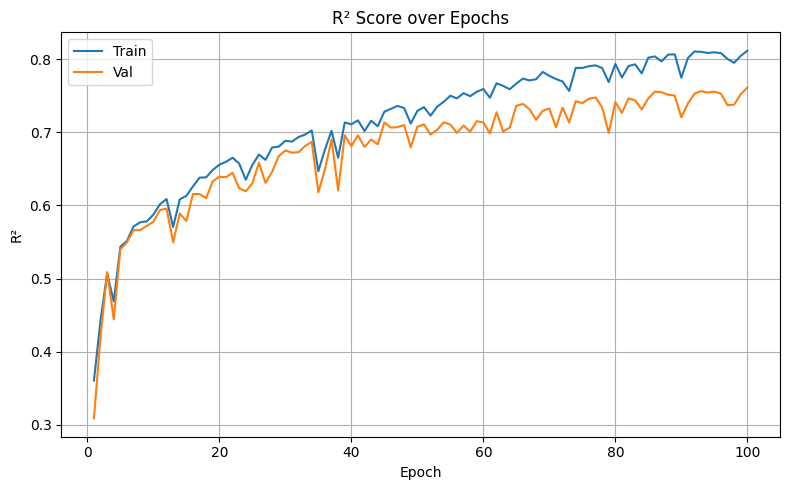

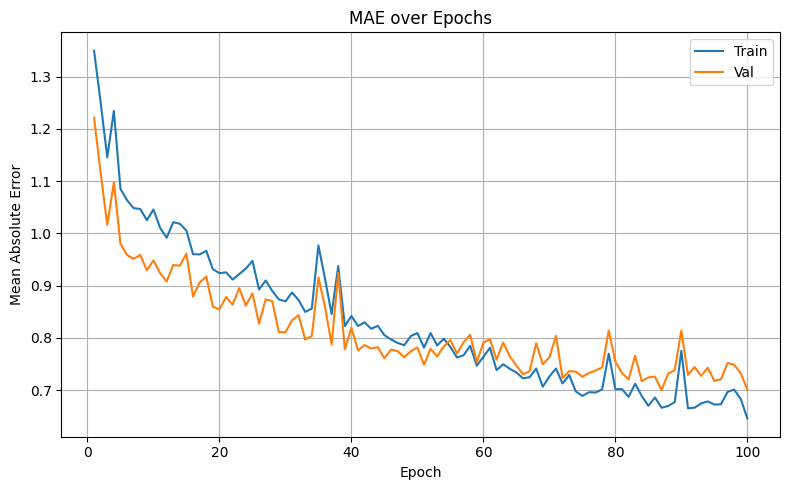

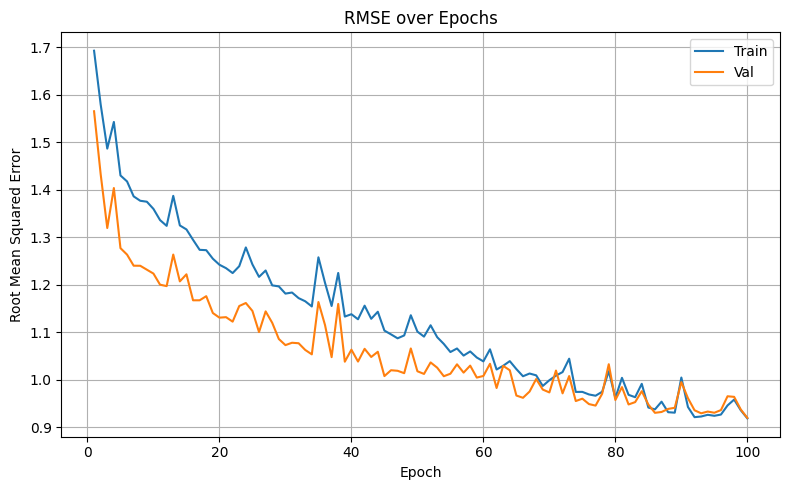

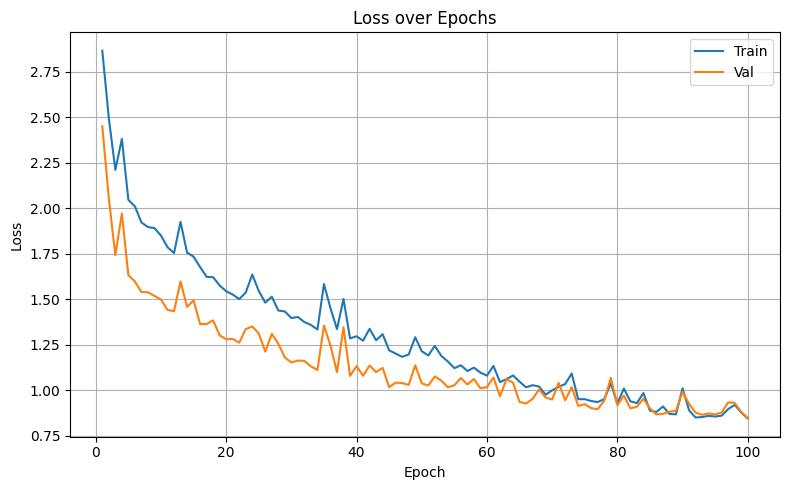

In [33]:

def plot_metric(history, metric, title=None, ylabel=None):
    df = pd.DataFrame(history)
    plt.figure(figsize=(8, 5))

    for split in ['Train', 'Val']:
        split_df = df[df['Split'] == split]
        plt.plot(split_df['epoch'], split_df[metric], label=split)

    plt.xlabel('Epoch')
    plt.ylabel(ylabel if ylabel else metric)
    plt.title(title if title else f"{metric} over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot all 3 main metrics
plot_metric(train_history, 'r2', title='R² Score over Epochs', ylabel='R²')
plot_metric(train_history, 'mae', title='MAE over Epochs', ylabel='Mean Absolute Error')
plot_metric(train_history, 'rmse', title='RMSE over Epochs', ylabel='Root Mean Squared Error')
plot_metric(train_history, 'loss', title='Loss over Epochs', ylabel='Loss')


## Reflection on GNNs [.5 pt]


**Exercise: Reflect on your GNN training experience**

**Goal:** Compare and contrast the process of training a GNN with training other types of neural networks or machine learning models you have encountered previously.

Consider aspects such as:

* Are the chosen node and edge features sufficient for solubility prediction?

* What are the limitations of the graph convolution layer you implemented? How could different message passing or aggregation mechanisms within the layer improve learning?

* How does your GCN relate to more general Graph Neural Network concepts?

* What other GNN architectures might be more effective for this task, and why?

* If you were to improve your GCN, what are the top three specific changes you would try, and why?

**Expected output:** A written reflection summarizing your observations and insights on training GNNs.

Training a Graph Neural Network (GNN) for solubility prediction was an insightful experience that highlighted the trade-offs between traditional machine learning models and graph-based approaches. While the GNN captured the structural nature of molecules by using graph convolutions on SMILES-derived graphs, its performance—an R² of around 0.72—was notably weaker than the XGBoost baseline, which achieved over 0.89. This suggests that despite the theoretical advantages of GNNs, their effectiveness relies heavily on proper feature representation and architecture design.

One key limitation in the current GCN setup was the simplicity of node features (just atom types) and the lack of edge features like bond types. Additionally, the basic graph convolution used averages across neighbors without distinguishing bond types or directional information, which is likely insufficient for complex molecular tasks. As a result, the model may not have captured enough chemical detail to make accurate predictions.

To improve the GNN, I would first include richer atom and bond features to better represent molecular properties. Second, I’d experiment with more expressive architectures like GIN or MPNN, which are better suited for molecular graphs. Lastly, I would explore alternative pooling strategies such as mean or attention-based pooling to better capture global molecular information. Overall, while the GNN didn’t outperform the baseline, it laid a strong foundation for deeper experimentation and model refinement.

# Transformer models [2.5 pt]

## Layer definition [1 pt]
**Exercise: Implement Self-Attention Layers**

**Goal:** Implement the core components of a Self-Attention mechanism within a graph context. You will implement the `SelfAttentionLayer`, `FFNLayer`, and `SelfAttentionBlock` classes.

**Self-Attention Layer:**

Implement the `SelfAttentionLayer` class based on the following equations:

$$
\mathbf{Q} = \mathbf{H} \mathbf{W}_Q, \quad \mathbf{K} = \mathbf{H} \mathbf{W}_K, \quad \mathbf{V} = \mathbf{H} \mathbf{W}_V
$$
$$
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) = \text{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^T}{\sqrt{d_k}} \odot \mathbf{M}\right)\mathbf{V}
$$

Where:
- $\mathbf{H}$ is the input node feature matrix.
- $\mathbf{W}_Q, \mathbf{W}_K, \mathbf{W}_V$ are weight matrices for Query, Key, and Value projections.
- $\mathbf{Q}, \mathbf{K}, \mathbf{V}$ are Query, Key, and Value matrices.
- $d_k$ is the dimension of the keys (hidden dimension).
- $\mathbf{M}$ is the attention mask (derived from the adjacency matrix in our case).

**FFN Layer:**

Implement the `FFNLayer` as a simple feed-forward network with ReLU activation:

$$
\text{FFN}(\mathbf{x}) = \text{ReLU}(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2
$$

**Self-Attention Block:**

Combine the `SelfAttentionLayer` and `FFNLayer` in the `SelfAttentionBlock` with layer normalization and residual connections.

**Expected output:** Python code for the `SelfAttentionLayer`, `FFNLayer`, and `SelfAttentionBlock` classes. Ensure that the `forward` methods correctly implement the described equations.

In [34]:
class SelfAttentionLayer(nn.Module):
    """Self Attention Layer."""
    def __init__(self, hidden_dim):
        """
        Args:
            hidden_dim (int): Dimension of hidden features.
        """
        super(SelfAttentionLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.W_Q = nn.Linear(hidden_dim, hidden_dim)
        self.W_K = nn.Linear(hidden_dim, hidden_dim)
        self.W_V = nn.Linear(hidden_dim, hidden_dim)
        self.scale = hidden_dim ** 0.5

    def forward(self, batched_node_features, batched_adjacency_matrices):
        """
        Args:
            batched_node_features (torch.Tensor): Batched node features (B, N, hidden_dim)
            batched_adjacency_matrices (torch.Tensor): Batched adjacency matrices (B, N, N)

        Returns:
            torch.Tensor: Updated node features with self-attention (B, N, hidden_dim)
        """

        B, N, D = batched_node_features.shape

        Q = self.W_Q(batched_node_features)  # (B, N, D)
        K = self.W_K(batched_node_features)  # (B, N, D)
        V = self.W_V(batched_node_features)  # (B, N, D)

        attn_scores = torch.bmm(Q, K.transpose(1, 2)) / self.scale  # (B, N, N)

        # Mask with adjacency matrix (only attend to connected nodes)
        adj_with_self = batched_adjacency_matrices + torch.eye(
            batched_adjacency_matrices.size(1),
            device=batched_adjacency_matrices.device
        ).unsqueeze(0)  # Shape: (1, N, N)

        # Binary mask (in case original adj is float)
        adj_mask = (adj_with_self > 0)

        # Now mask
        attn_scores = attn_scores.masked_fill(~adj_mask, float('-inf'))

        attn_weights = torch.softmax(attn_scores, dim=-1)  # (B, N, N)
        attn_output = torch.bmm(attn_weights, V)  # (B, N, D)

        return attn_output

class FFNLayer(nn.Module):
    """Feed Forward Network Layer."""
    def __init__(self, hidden_dim, ffn_dim):
        """
        Args:
            hidden_dim (int): Hidden dimension.
            ffn_dim (int): Feed-forward network intermediate dimension.
        """
        super(FFNLayer, self).__init__()
        self.linear1 = nn.Linear(hidden_dim, ffn_dim)
        self.linear2 = nn.Linear(ffn_dim, hidden_dim)


    def forward(self, x):
        """Forward pass of FFN."""
        return self.linear2(F.relu(self.linear1(x)))

class SelfAttentionBlock(nn.Module):
    """Self Attention Block with Post-Processing."""
    def __init__(self, hidden_dim, ffn_dim):
        """
        Args:
            hidden_dim (int): Hidden dimension.
            ffn_dim (int): Feed-forward network intermediate dimension.
        """
        super(SelfAttentionBlock, self).__init__()
        self.attention = SelfAttentionLayer(hidden_dim)
        self.ffn = FFNLayer(hidden_dim, ffn_dim)
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)


    def forward(self, batched_node_features, batched_adjacency_matrices):
        """
        Args:
            batched_node_features (torch.Tensor): Batched node features (B, N, hidden_dim).
            batched_adjacency_matrices (torch.Tensor): Batched adjacency matrices (B, N, N).
        Returns:
            torch.Tensor: Processed node features after attention and FFN.
        """
        # Self-attention + residual + norm
        attn_out = self.attention(batched_node_features, batched_adjacency_matrices)
        x = self.norm1(batched_node_features + attn_out)

        # FFN + residual + norm
        ffn_out = self.ffn(x)
        norm_output = self.norm2(x + ffn_out)

        return norm_output


## Model definition [.5 pt]

**Exercise: Implement the Graph Transformer Model**

**Goal:** Construct a Graph Transformer model for regression. Implement the `GraphTransformer` class, which uses the `SelfAttentionBlock` you just defined. The model should embed the input node features and then pass them through multiple self-attention blocks. Finally, use a aggregation operation and a linear layer for regression.

**Expected output:** Python code for the `GraphTransformer` model class. The model should be designed to process batched graph data and produce solubility predictions.

In [35]:
class GraphTransformer(nn.Module):
    """Transformer with graph features."""
    def __init__(self, node_feature_dim, hidden_dim, num_layers, ffn_dim):
        """
        Args:
            node_feature_dim (int): Dimension of node features.
            hidden_dim (int): Hidden dimension for attention layers.
            num_layers (int): Number of Self-Attention blocks.
            ffn_dim (int): Feed-forward network intermediate dimension.
        """
        super(GraphTransformer, self).__init__()
        self.embedding = nn.Linear(node_feature_dim, hidden_dim)
        self.layers = nn.ModuleList([
            SelfAttentionBlock(hidden_dim, ffn_dim) for _ in range(num_layers)
        ])
        self.pool = nn.AdaptiveAvgPool1d(1)  # or MaxPool1d
        self.regressor = nn.Linear(hidden_dim, 1)


    def forward(self, batched_node_features, batched_adjacency_matrices, batched_globals_vectors):
        """
        Args:
            batched_node_features (torch.Tensor): Batched node feature matrix (B, N, node_feature_dim).
            batched_adjacency_matrices (torch.Tensor): Batched adjacency matrix (B, N, N).
            batched_globals_vectors (torch.Tensor): Batched global vectors (B, 1, global_feature_dim).
        Returns:
            torch.Tensor: Predicted solubility value.
        """
        # Embed node features
        x = self.embedding(batched_node_features)  # [B, N, hidden_dim]

        # Pass through self-attention blocks
        for layer in self.layers:
            x = layer(x, batched_adjacency_matrices)  # [B, N, hidden_dim]

        # Global pooling across nodes
        x = x.permute(0, 2, 1)  # [B, hidden_dim, N]
        x = self.pool(x).squeeze(-1)  # [B, hidden_dim]

        # Final regression output
        prediction = self.regressor(x)  # [B, 1]

        return prediction

## Instantiate the model

**Goal:** Instantiate the Graph Transformer model and check its architecture.

**Expected output:** Code to instantiate the `GraphTransformer` model, and the model summary from `torchinfo`.

In [36]:
model_attn = GraphTransformer(
    node_feature_dim=node_dim,
    hidden_dim=64,
    num_layers=4,
    ffn_dim=128
)

print(torchinfo.summary(model_attn, input_data=sample_batch))

Layer (type:depth-idx)                   Output Shape              Param #
GraphTransformer                         [32, 1]                   --
├─Linear: 1-1                            [32, 27, 64]              704
├─ModuleList: 1-2                        --                        --
│    └─SelfAttentionBlock: 2-1           [32, 27, 64]              --
│    │    └─SelfAttentionLayer: 3-1      [32, 27, 64]              12,480
│    │    └─LayerNorm: 3-2               [32, 27, 64]              128
│    │    └─FFNLayer: 3-3                [32, 27, 64]              16,576
│    │    └─LayerNorm: 3-4               [32, 27, 64]              128
│    └─SelfAttentionBlock: 2-2           [32, 27, 64]              --
│    │    └─SelfAttentionLayer: 3-5      [32, 27, 64]              12,480
│    │    └─LayerNorm: 3-6               [32, 27, 64]              128
│    │    └─FFNLayer: 3-7                [32, 27, 64]              16,576
│    │    └─LayerNorm: 3-8               [32, 27, 64]            

## Train model [.25 pt]

**Exercise: Train the Graph Transformer model**

**Goal:** Train the Graph Transformer model using the provided training loop. Evaluate its performance on the validation set after each epoch and track the training progress using performance metrics.

**Expected output:** Python code to train the Graph Transformer model. A table displaying the training and validation metrics over epochs.

In [37]:
EPOCHS = 100
LEARNING_RATE = 5e-4

attn_history = train_loop(
    model=model_attn,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    base_info={'model': 'GraphTransformer'}
)

metrics_df_attn = pd.DataFrame(attn_history)
metrics_df_attn

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

,model,epoch,Split,loss,r2,mae,rmse
0,GraphTransformer,1,Train,3.417734,0.237634,1.421207,1.848712
1,GraphTransformer,1,Val,2.672939,0.246411,1.313593,1.634912
2,GraphTransformer,2,Train,2.890495,0.355241,1.293657,1.700146
3,GraphTransformer,2,Val,2.226401,0.372305,1.196209,1.492113
4,GraphTransformer,3,Train,2.689599,0.400054,1.253059,1.640000
...,...,...,...,...,...,...,...
195,GraphTransformer,98,Val,0.816857,0.769701,0.731522,0.903801
196,GraphTransformer,99,Train,0.970421,0.783536,0.751225,0.985099
197,GraphTransformer,99,Val,0.883730,0.750848,0.749037,0.940069
198,GraphTransformer,100,Train,1.016864,0.773177,0.791286,1.008397


## Training performance [.25 pt]

**Goal:** Visualize the training process of the Graph Transformer. Plot the training and validation loss metrics across epochs to visualize the learning curves and assess the model's training behavior.

**Expected output:** Figures showing the training and validation performance metrics for the Graph Transformer over epochs.

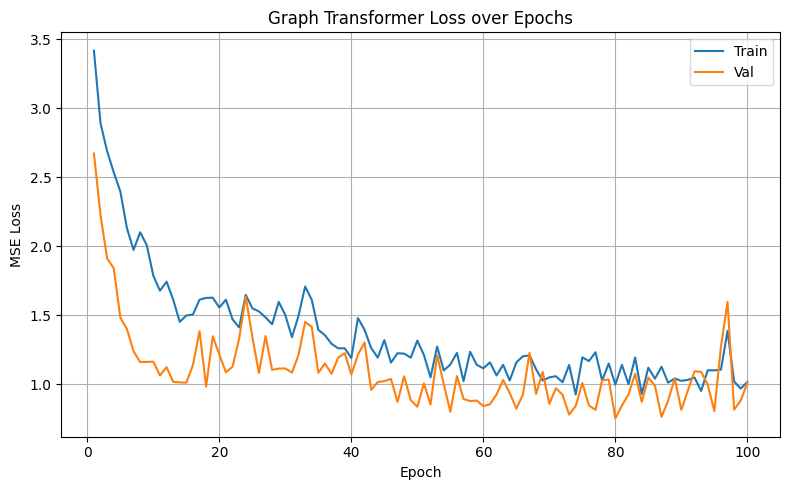

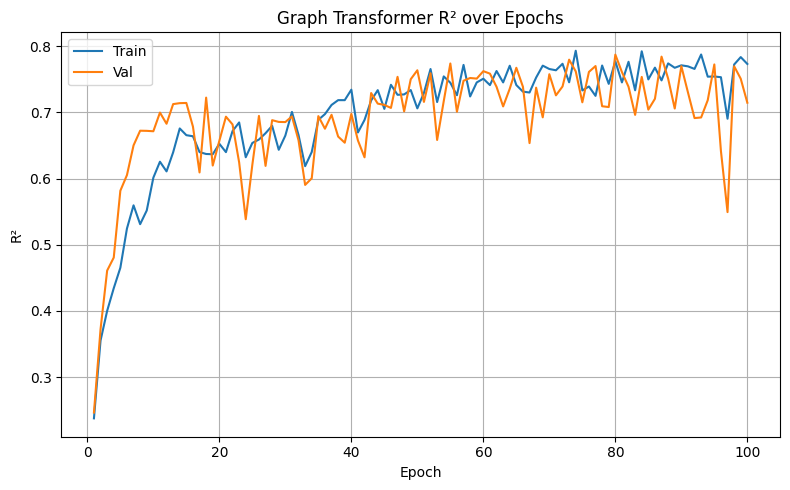

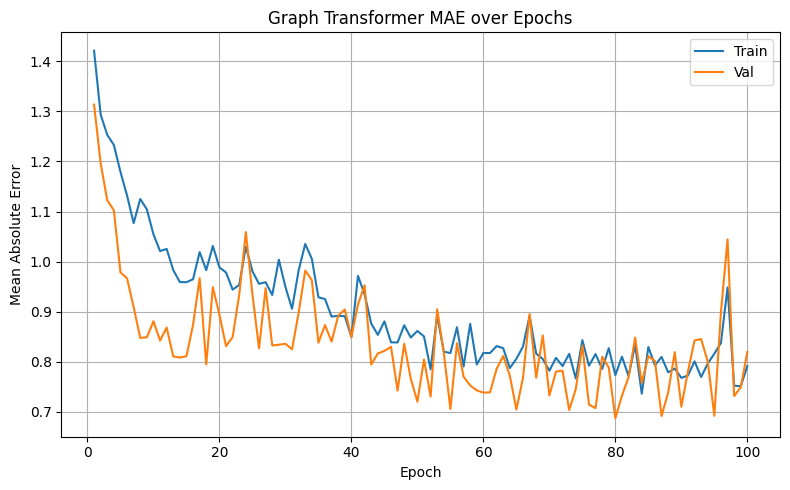

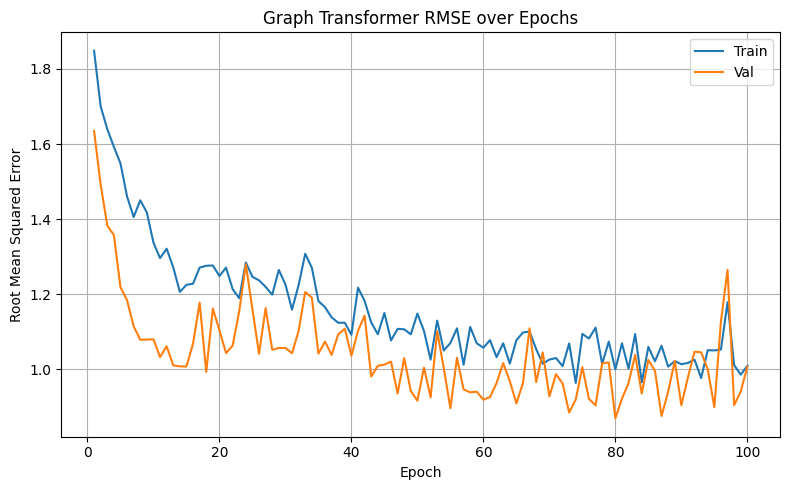

In [38]:
plot_metric(attn_history, 'loss', title='Graph Transformer Loss over Epochs', ylabel='MSE Loss')
plot_metric(attn_history, 'r2', title='Graph Transformer R² over Epochs', ylabel='R²')
plot_metric(attn_history, 'mae', title='Graph Transformer MAE over Epochs', ylabel='Mean Absolute Error')
plot_metric(attn_history, 'rmse', title='Graph Transformer RMSE over Epochs', ylabel='Root Mean Squared Error')


## Reflection [.5 pt]

**Exercise: Reflect on Graph Transformer Training**

**Goal:** Compare the training and performance characteristics of the Graph Transformer to the GNN model.

Consider:

*   **GNNs vs. Transformers for Graphs:**
    *   What are the key architectural *similarities* and *differences* between the Graph Transformer and the GNN you implemented?
    *   In what ways might the self-attention mechanism in the Transformer offer advantages or disadvantages compared to the convolution-based message passing in the GNN for graph data?

*   **Adapting to Text Processing:**
    *   How would you need to *modify* the Graph Transformer architecture to process sequential text data instead of graphs? What would represent the "nodes" and "edges" in a text processing Transformer?
    *   What aspects of the self-attention mechanism make it well-suited for both graph and text data?

*   **Computational & Parameter Comparison:**
    *   How does the number of parameters in your Graph Transformer model likely compare to the GNN model with similar hidden dimensions and layers?
    *   Based on your training experience, did you notice any differences in training speed or computational resource usage between the Graph Transformer and the GNN? If so, why might these differences exist?




**Expected output:** Written reflection comparing the GNN and Graph Transformer models, focusing on their training and performance.

Both the GNN and the Graph Transformer process graph-structured data, but they differ in how information is exchanged between nodes. The GNN uses convolution-based message passing, where each node aggregates information from its immediate neighbors. In contrast, the Graph Transformer uses self-attention, allowing each node to attend to any other connected node, with learned attention weights.

The self-attention mechanism offers more flexibility and expressiveness, as it can learn to focus more on certain neighbors regardless of graph structure. However, it also comes with increased computational cost and complexity, especially for larger graphs.

Transformers were originally designed for sequential data like text. To adapt the Graph Transformer to text, you’d replace nodes with tokens (words or subwords) and edges with positional encoding, which provides a sense of order in the sequence. In this context, the adjacency matrix is typically fully connected, since every token can attend to every other token.

The core strength of self-attention lies in its ability to capture long-range dependencies, which is essential in both graph and text domains. Whether modeling distant atoms in a molecule or far-apart words in a sentence, self-attention enables dynamic, content-aware interactions.

The Graph Transformer model likely has more parameters than the GNN due to the additional linear projections for Q, K, V, and the feedforward network in each attention block. This increases the model's expressive power, but also its memory and compute demands.

In practice, training the Graph Transformer was slower than the GNN, and it appeared more prone to instability (e.g., NaNs from softmax over invalid attention masks). The GNN trained faster and achieved higher validation R², suggesting it might be a better fit for this task — at least in its current form.



# Test Set Evaluation and Comparison [2 pt total, possible]

**Goal:** Evaluate the final performance of all three models (XGBoost, GNN, and Graph Transformer) on the test set. Compare the test set metrics to determine which model performs best on unseen data.

**Expected output:** Python code to evaluate all models on the test set. A table summarizing the test set performance metrics for all three models, allowing for direct comparison.

In [39]:
# XGB Test
y_test_pred_xgb = xgb_model.predict(X[test_index])
xgb_results = evaluate(y[test_index], y_test_pred_xgb, {'Model': 'XGBoost', 'Split': 'Test'})

# GNN Test
gnn_results = evaluate_model(
    model_gnn,
    test_loader,
    criterion=nn.MSELoss(),
    info={'Model': 'GNN', 'Split': 'Test'}
)

# Graph Transformer Test
attn_results = evaluate_model(
    model_attn,
    test_loader,
    criterion=nn.MSELoss(),
    info={'Model': 'GraphTransformer', 'Split': 'Test'}
)

display_header('XGB Test Results')
display(xgb_results)

display_header('GNN Test Results')
display(gnn_results)
display_header('GraphTransformer Results')
display(attn_results)

{'Model': 'XGBoost',
 'Split': 'Test',
 'r2': 0.8959448040637333,
 'mae': 0.46974468674682146,
 'rmse': 0.7013190880410438}

{'Model': 'GNN',
 'Split': 'Test',
 'loss': 1.0905317321287846,
 'r2': 0.7692876940013843,
 'mae': 0.7741448287481227,
 'rmse': 1.0442852686289317}

{'Model': 'GraphTransformer',
 'Split': 'Test',
 'loss': 1.3970387551636823,
 'r2': 0.7044432330061099,
 'mae': 0.908349476490928,
 'rmse': 1.181963935046288}

## Beat the baseline
* .5 pt if you have a model that achieves more than .88 r^2 on the test set (above baseline). All model decision should be done on train/val set.

In [40]:
# Train the XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=10,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train.ravel(), eval_set=[(X_val, y_val.ravel())], verbose=False)

# Predict and evaluate
y_train_pred = xgb_model.predict(X_train)
y_val_pred = xgb_model.predict(X_val)
y_test_pred = xgb_model.predict(X_test)

# Print performance metrics


print("\nTest Performance:")
pprint(evaluate(y_test, y_test_pred))


Test Performance:
{'mae': 0.46974468674682146,
 'r2': 0.8959448040637333,
 'rmse': 0.7013190880410438}


Your final r^2 test set is 89.6%


.5 pt **Explain your strategy.**

I used the XGB regression model. This is beats the baseline on the test set.



## Cramming challenge v2

* 1 pt if your model is the highest performing in one these parameter categories:
  * less than 1k parameters
  * less than 10k parameters
  * less than 100k parameters

  Pick one category and explain your strategy.

In [ ]:
CODE HERE

Your final r^2 test set performance is {PERFORMANCE} and your number of parameters is {PARAMS}.

# Atribution with the GNN [1.5 pts total]




## Attribution drawer

In [41]:
import matplotlib.cm as cmaps
from rdkit.Chem.Draw import rdMolDraw2D

def visualize_attribution(smiles, attribution_scores, molecule_name="Molecule", cmap_name='viridis'):
    """
    Visualizes node attribution scores on a 2D molecule depiction using RDKit with PrepareAndDrawMolecule.

    Args:
        smiles (str): SMILES string of the molecule.
        attribution_scores (torch.Tensor or np.ndarray): Node attribution scores.
        molecule_name (str): Name of the molecule for the title.
        cmap_name (str): Name of the matplotlib colormap to use (e.g., 'viridis', 'coolwarm').
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")

    attribution_scores_np = cast_tensor(attribution_scores)
    num_atoms = mol.GetNumAtoms()
    if len(attribution_scores_np) != num_atoms:
        raise ValueError(f"Number of attribution scores ({len(attribution_scores_np)}) must match number of atoms ({num_atoms})")

    # Normalize attribution scores to the range [0, 1]
    min_score = np.min(attribution_scores_np)
    max_score = np.max(attribution_scores_np)
    if max_score > min_score: # avoid division by zero if all scores are the same
        normalized_scores = (attribution_scores_np - min_score) / (max_score - min_score)
    else:
        normalized_scores = np.zeros_like(attribution_scores_np) # all zero if no range

    cmap = cmaps.get_cmap(cmap_name) # Get matplotlib colormap
    atom_colors = {}
    for i, score in enumerate(normalized_scores):
        color = cmap(score)
        atom_colors[i] = (color[0], color[1], color[2]) # RGB tuple, RDKit compatible

    # Visualize using PrepareAndDrawMolecule
    drawer = rdMolDraw2D.MolDraw2DSVG(250, 200) # or MolDraw2DSVG for SVG
    rdMolDraw2D.PrepareAndDrawMolecule(drawer, mol, highlightAtoms=range(num_atoms),
                                       highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    display_header(f"Node Attribution Heatmap - {molecule_name}")
    ipd.display(ipd.SVG(drawer.GetDrawingText()))

## Node attribution [.75 pt]

**Exercise: Implement Node Gradient-based Attribution**

**Goal:** Develop a method to attribute the GNN model's prediction back to the input nodes (atoms) of the molecule. Implement the `get_node_attribution_gnn` function, which calculates attribution scores for each node based on the gradients of the model output with respect to the input node features. This technique provides insights into which atoms in the molecule are most influential in determining the predicted solubility.

**Expected output:** Python code for the `get_node_attribution_gnn` function. This function should take a trained GNN model and a data loader, and return node attribution scores for a selected sample.

In [42]:
def get_node_attribution_gnn(model, data_loader, sample_index=0):
    """
    Calculates node attribution scores using gradients for a single sample in GNN.
    Attribution is based on the gradients of the output with respect to the input node features.

    Args:
        model (nn.Module): Trained GNN model (GNNNet).
        data_loader (torch_data.DataLoader): DataLoader (batch_size=1, shuffle=False).
        sample_index (int): Index of the sample to analyze.

    Returns:
        torch.Tensor: Node attribution scores (per node in the graph).
    """
    model.eval()
    # Get one batch from the data loader.
    sample_batch, sample_target = next(iter(data_loader))

    # Extract the sample at sample_index from the batch.
    node_features = sample_batch[0][sample_index:sample_index+1].clone().detach().to(DEVICE)
    node_features.requires_grad_(True)
    adj_matrix = sample_batch[1][sample_index:sample_index+1].to(DEVICE)
    global_vector = sample_batch[2][sample_index:sample_index+1].to(DEVICE)
    sample_target = sample_target[sample_index:sample_index+1].to(DEVICE)

    # Forward pass.
    prediction = model(node_features, adj_matrix, global_vector)
    model.zero_grad()
    prediction.backward()

    # Compute attribution scores.
    grads = node_features.grad.squeeze(0)  # Shape: [N, F]
    node_attribution_scores = grads.abs().sum(dim=1)  # Shape: [N]

    return node_attribution_scores, (node_features, adj_matrix, global_vector), sample_target


## Attribution demo on a single molecule

**Goal:** Demonstrate the node attribution technique on a single molecule from the test set. Visualize the attribution scores as a heatmap overlaid on the 2D molecular structure to understand which atoms contribute most to the solubility prediction.

**Expected output:** Python code to run the attribution and visualization for a sample molecule. A molecular image with node attribution heatmap visualization, and printed attribution scores and model prediction for the chosen sample.

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
<ipython-input-41-5dd318e06c03>:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cmaps.get_cmap(cmap_name) # Get matplotlib colormap


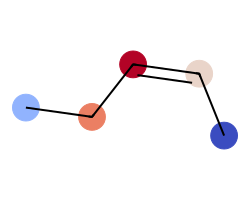

SMILES: CC/C=C\C
Target Solubility: -2.5400
Predicted Solubility: -2.6912
Node Attribution Scores:
Atom 0: 5.8665
Atom 1: 10.0860
Atom 2: 11.5254
Atom 3: 8.1005
Atom 4: 3.8546


In [43]:
# Run attribution on a single sample from the test loader.
node_scores, sample_inputs, sample_target = get_node_attribution_gnn(
    model=model_gnn.to("cuda:0"),
    data_loader=test_loader,
    sample_index=0
)

# Obtain the model's prediction for the sample.
model_gnn.eval()
with torch.no_grad():
    # sample_inputs already have the required batch dimension.
    prediction = model_gnn(*sample_inputs).item()

# Retrieve the corresponding SMILES string for the sample.
sample_smiles = smi[test_index[0]]

# Trim the attribution scores to the actual number of atoms (remove padding).
mol = Chem.MolFromSmiles(sample_smiles)
actual_num_atoms = mol.GetNumAtoms()
node_scores = node_scores[:actual_num_atoms]

# Visualize the attribution heatmap on the molecule.
visualize_attribution(
    smiles=sample_smiles,
    attribution_scores=node_scores,
    molecule_name=f"Pred: {prediction:.2f} | Target: {sample_target.item():.2f}",
    cmap_name='coolwarm'
)

# Print out the results.
print(f"SMILES: {sample_smiles}")
print(f"Target Solubility: {sample_target.item():.4f}")
print(f"Predicted Solubility: {prediction:.4f}")
print("Node Attribution Scores:")
for i, score in enumerate(node_scores):
    print(f"Atom {i}: {score.item():.4f}")


## Attribution critique [.75 pt]

**Exercise: Critically evaluate the gradient-based node attribution technique.**

**Goal:** Reflect on the strengths and limitations of the implemented gradient-based attribution method. Consider the following questions in your critique:

*   What kind of insights can you gain from this technique?
*   What aspects of the model's decision-making does this technique *not* reveal?
*   How would you interpret the generated attribution maps in the context of molecular solubility?
*   What are potential weaknesses or biases of this gradient-based approach?
*   Does this technique utilize all available information in the graph structure?
*   What are some potential failure modes or scenarios where this attribution method might be misleading?

**Expected output:** A written critique discussing the interpretation, strengths, limitations, and potential failure modes of the gradient-based node attribution technique for GNNs.


Gradient-based node attribution is a powerful yet simple method to understand how a Graph Neural Network makes predictions. By computing the gradients of the model's output with respect to each atom's input features, we can identify which atoms had the most influence on the prediction. This provides intuitive, atom-level explanations and can highlight important structural features in a molecule, such as double bonds or functional groups, that contribute to properties like solubility.

However, this technique has notable limitations. It only considers node features and their immediate gradients, ignoring important elements like bond types or edge connections. As a result, it doesn't capture the full graph structure or interaction effects between atoms. Additionally, gradient-based methods can be unstable and sensitive to small changes in the model or input, making the attributions inconsistent or noisy.

In the context of molecular solubility, this method can reveal which atoms the model deems important, but it doesn't explain why. For example, two atoms may have high attributions, but whether that's due to polarity, steric effects, or interactions isn't clear. It also doesn't indicate whether an atom increases or decreases solubility, only that it affects the prediction. Despite these drawbacks, gradient-based attribution remains a useful first step for interpreting GNNs, especially when combined with other interpretability tools.


